# Modeling

In [115]:
# Import libraries
import re 
import ast 
import json 
import pickle 
from collections import Counter 
import datetime as dt
import pybaseball
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from pybaseball import pitching_stats_bref
from pybaseball import statcast
from pybaseball import statcast_pitcher
from pybaseball import playerid_lookup
from pybaseball import playerid_reverse_lookup

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

- XGBoost
- Random Forest
- RNN (LSTM or GRU or both)

RNN will likely take too long depending on how the number of features.

In [116]:
data = pd.read_csv('../data/final/pitch_by_pitch_2023_ml.csv')

In [118]:
data.drop(columns=['game_type', 'inning_topbot', 'if_fielding_alignment', 'of_fielding_alignment', 'count', 'game_pitcher_id'], inplace=True)

In [119]:
data['prev_pitch_type'] = data['prev_pitch_type'].astype(str)

In [120]:
data['prev_pitch_type'] = data['prev_pitch_type'].replace('nan', 'Unknown')

In [121]:
# Drop all rows where prev_pitch_type is UN
data = data[data.prev_pitch_type != 'Unknown']

In [122]:
data['pitch_type'].value_counts()

pitch_type
Fastball         286240
Breaking Ball    150978
Off-Speed         55266
Specialty            66
Name: count, dtype: int64

In [123]:
data['prev_pitch_type'].value_counts()

prev_pitch_type
Fastball         283970
Breaking Ball    152355
Off-Speed         56159
Specialty            66
Name: count, dtype: int64

In [124]:
data['pitch_type'].isna().sum()

0

In [198]:
def preprocess_data(data):

    data.drop(columns=['game_type', 'inning_topbot', 'if_fielding_alignment', 'of_fielding_alignment', 'count', 'game_pitcher_id'], inplace=True)
    
    data['prev_pitch_type'] = data['prev_pitch_type'].replace('nan', 'Unknown')
    data = data[data.prev_pitch_type != 'Unknown']
    
    data['pitch_type'] = data['pitch_type'].astype(str)
    data['prev_pitch_type'] = data['prev_pitch_type'].astype(str)

    data = data[data.pitch_type != 'Specialty']
    data = data[data.prev_pitch_type != 'Specialty']
    
    return data

In [131]:
data2 = pd.read_csv('../data/final/five_2023_ml.csv')

In [132]:
data2.drop(columns=['game_type', 'inning_topbot', 'if_fielding_alignment', 'of_fielding_alignment', 'count', 'game_pitcher_id'], inplace=True)

In [149]:
data2['prev_pitch_type'] = data2['prev_pitch_type'].astype(str)

In [150]:
data2['pitch_type'] = data2['pitch_type'].astype(str)

In [134]:
data2['prev_pitch_type'] = data2['prev_pitch_type'].replace('nan', 'Unknown')

In [135]:
# Drop all rows where prev_pitch_type is UN
data2 = data2[data2.prev_pitch_type != 'Unknown']

In [200]:
# Drop Specialty from both pitch_type and prev_pitch_type
data2 = data2[data2.pitch_type != 'Specialty']
data2 = data2[data2.prev_pitch_type != 'Specialty']

In [172]:
data2['pitch_type'].value_counts()

pitch_type
PFastball        162370
Breaking Ball    150978
MFastball        123870
Off-Speed         55266
Specialty            66
Name: count, dtype: int64

In [173]:
data2['prev_pitch_type'].value_counts()

prev_pitch_type
PFastball        160349
Breaking Ball    152355
MFastball        123621
Off-Speed         56159
Specialty            66
Name: count, dtype: int64

## XGBoost

Below I'm using the XGBoost algorithm to train pitcher-specific models for my goal of pitch prediction. The function loops through every pitcher who has pitched above the cutoff (default 1000 but can be manually set) and trains on

In [206]:
def train_xgb_models(train_data, pitch_count_cutoff=1000):
    '''
    Function to train and test models for pitch prediction for individual pitchers
    
    train_data: a cleaned data frame
    pitch_count_cutoff: a minimum number of pitches thrown  
    
    returns a pickled file for each pitcher that contains the model and some metadata for that pitcher
    '''

    # build a dict with pitch_id as key and total pitch count as value
    pitcher_count_dict = dict(Counter(train_data['pitcher']))

    # drop pitchers that don't have enough pitches to build a reliable model
    pitcher_count_dict = {k:v for k, v in pitcher_count_dict.items() if v > pitch_count_cutoff}

    # list of pitchers
    pitcher_list = pitcher_count_dict.keys()
    print(f"Number of pitchers that make the cut: {len(pitcher_count_dict)}")

    # loop through the list of pitchers and train models
    accuracy_list = []
    naive_accuracy_list = []
    num_skipped = 0
    for i, pitcher in enumerate(pitcher_list):

        # start a timer
        start = dt.datetime.now()

        df_pitcher = train_data[train_data['pitcher'] == pitcher]
        df_pitcher.drop('pitcher', axis=1, inplace=True)

        # get a unique list of the pitcher's pitches
        pitch_types = list(set(list(df_pitcher['prev_pitch_type'].unique()) + list(df_pitcher['pitch_type'].unique())))
        pitch_type_counts = Counter(df_pitcher['prev_pitch_type'])

        # build maps for pitches to ints and ints back to pitches
        pitch_map = {pitch_types[i]: i for i in range(len(pitch_types))}
        pitch_unmap = {v: k for k, v in pitch_map.items()}

        # map pitch types to ints
        df_pitcher['pitch_type'] = df_pitcher['pitch_type'].apply(lambda x: pitch_map[x])
        df_pitcher['prev_pitch_type'] = df_pitcher['prev_pitch_type'].apply(lambda x: pitch_map[x])

        # split the dataframe into a feature set and an outcome column
        X = df_pitcher.drop('pitch_type', axis=1)
        y = df_pitcher['pitch_type']

        # split the data into train/test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        """
        if len(np.unique(y_train)) > len(np.unique(y_test)):
            unique_classes = len(y_train.unique())
        else:
            unique_classes = len(y_test.unique())
        
        if len(np.unique(y_train)) > len(np.unique(y_test)):
            # Get all unique classes from y_train
            all_classes = np.unique(y_train)

            # Align the test labels with the training classes
            y_test = pd.Categorical(y_test, categories=all_classes).codes
        else:
            # Get all unique classes from y_test
            all_classes = np.unique(y_test)

            # Align the training labels with the test classes
            y_train = pd.Categorical(y_train, categories=all_classes).codes
        """
        # ----------------------
        # train an XGBoost model
        # ----------------------

        # small set of hyperparameters to optimize over
        xgb_params = {"max_depth": (2, 5, 20),
                      "learning_rate": (0.01, 0.1, 0.4)}
        
        # perform the paramater grid search using 5-fold cross validation
        xgb_opt = GridSearchCV(XGBClassifier(objective='multi:softprob', num_class=len(pitch_type_counts)), 
                               param_grid=xgb_params, cv=5, scoring='accuracy', verbose=0, n_jobs=-1)

        # perform fit and make predictions
        xgb_opt.fit(X_train, y_train)
        y_pred = xgb_opt.predict(X_test)
        y_prob = xgb_opt.predict_proba(X_test)

        # compute accuracy and store in a list for analyzing results later
        accuracy = round(accuracy_score(y_test, y_pred) * 100, 1)
        accuracy_list.append(accuracy)

        # get and store the naive accuracy (accuracy from just predicting the most thrown pitch)
        naive_accuracy = round(max(pitch_type_counts.values()) / sum(pitch_type_counts.values()) * 100., 1)
        naive_accuracy_list.append(naive_accuracy)

        # print some input/results for every 10th pitcher
        if i % 10 == 0:
            print()
            print(f"Pitcher ID: {pitcher}")
            print(f"Pitcher's pitch map: {pitch_map}")
            print(f"Pitcher's pitch counter: {dict(pitch_type_counts)}")
            print(f"Number of data points in training: {X_train.shape[0]}")
            print(f"Number of data points in testing: {X_test.shape[0]}")
            print(f"Best params: {xgb_opt.best_params_}")
            print(f"Total training time: {dt.datetime.now()-start}")
            print(f"Naive accuracy: {naive_accuracy}")
            print(f"XGBooost accuracy: {accuracy}")


        # ----------------------------------------------------------
        # write out the pitchers model and metadata to a pickle file
        # ----------------------------------------------------------

        # things to store in the pitcher's model file:
        #  1) the map and unmap for pitches (used for data clean-up in the prediction process)
        #  2) trained model (used to make prediction)
        #  3) accuracy on the test data (to include with pitch predictions so user can see how confident the model is)
        model_out = {
            "pitcherID": pitcher,
            "pitch_map": pitch_map,
            "pitch_unmap": pitch_unmap,
            "model": xgb_opt,
            "model_accuracy": accuracy
        }

        # pickle up the pitcher's model file
        fpath = "../data/pitcher_models/" + str(pitcher) + ".pkl"
        with open(fpath, 'wb') as fobj:
            pickle.dump(model_out, fobj)
           
    # return the accuracy lists so we can perform assessment 
    return accuracy_list, naive_accuracy_list

---

### Five categories 2023 season

In [212]:
accuracy_list, naive_accuracy_list = train_xgb_models(data2, pitch_count_cutoff=2400)

Number of pitchers that make the cut: 65

Pitcher ID: 622491
Pitcher's pitch map: {'MFastball': 0, 'Breaking Ball': 1, 'Off-Speed': 2, 'PFastball': 3}
Pitcher's pitch counter: {'MFastball': 556, 'PFastball': 1408, 'Breaking Ball': 710, 'Off-Speed': 500}
Number of data points in training: 2539
Number of data points in testing: 635
Best params: {'learning_rate': 0.1, 'max_depth': 5}
Total training time: 0:00:01.896866
Naive accuracy: 44.4
XGBooost accuracy: 80.6

Pitcher ID: 605483
Pitcher's pitch map: {'Breaking Ball': 0, 'Off-Speed': 1, 'PFastball': 2}
Pitcher's pitch counter: {'Breaking Ball': 1042, 'PFastball': 1510, 'Off-Speed': 584}
Number of data points in training: 2508
Number of data points in testing: 628
Best params: {'learning_rate': 0.1, 'max_depth': 5}
Total training time: 0:00:00.992865
Naive accuracy: 48.2
XGBooost accuracy: 94.9

Pitcher ID: 669302
Pitcher's pitch map: {'Breaking Ball': 0, 'PFastball': 1, 'MFastball': 2}
Pitcher's pitch counter: {'PFastball': 1192, 'Brea

### Visualizing the results

Percentage of pitcher models with accuracy improvement over naive prediction: 100.0%


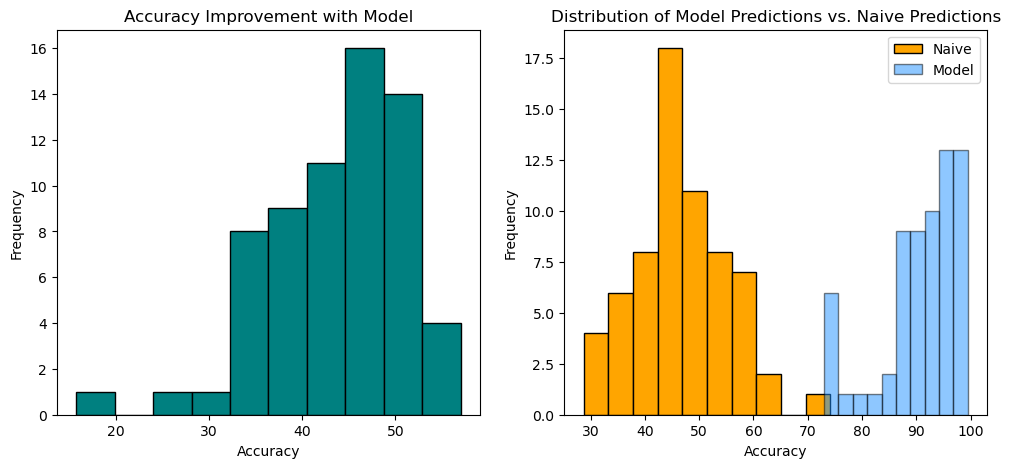

In [232]:
accuracy_diff_list = [accuracy_list[i] - naive_accuracy_list[i] for i in range(len(accuracy_list))]
pos_diff_list = [x for x in accuracy_diff_list if x > 0.]
improve_pct = round(len(pos_diff_list) / len(accuracy_diff_list) * 100., 1)
print(f"Percentage of pitcher models with accuracy improvement over naive prediction: {improve_pct}%")

fig = plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.hist(accuracy_diff_list, bins=10, color='teal', edgecolor='black')
plt.title("Accuracy Improvement with Model")
plt.ylabel("Frequency")
plt.xlabel("Accuracy")

plt.subplot(1, 2, 2)
plt.hist(naive_accuracy_list, bins=10, label='Naive', color='orange', edgecolor='black')
plt.hist(accuracy_list, bins=10, alpha=0.5, label='Model', color='dodgerblue', edgecolor='black')
plt.title("Distribution of Model Predictions vs. Naive Predictions")
plt.ylabel("Frequency")
plt.xlabel("Accuracy")
plt.legend(loc='best')
plt.show()

---

### Five categories 2024 season

In [195]:
data3 = pd.read_csv('../data/final/five_2024_ml.csv')

In [197]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500605 entries, 0 to 500604
Data columns (total 32 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   pitch_type                         500605 non-null  object 
 1   release_speed                      500605 non-null  float64
 2   batter                             500605 non-null  int64  
 3   pitcher                            500605 non-null  int64  
 4   game_type                          500605 non-null  object 
 5   balls                              500605 non-null  int64  
 6   strikes                            500605 non-null  int64  
 7   on_3b                              500605 non-null  int64  
 8   on_2b                              500605 non-null  int64  
 9   on_1b                              500605 non-null  int64  
 10  outs_when_up                       500605 non-null  int64  
 11  inning                             5006

In [ ]:
preprocess_data(data3)

In [219]:
data3 = data3[data3.pitch_type != 'Specialty']
data3 = data3[data3.prev_pitch_type != 'Specialty']

In [235]:
def train_xgb_models_2024(train_data, pitch_count_cutoff=1000):
    '''
    Function to train and test models for pitch prediction for individual pitchers
    
    train_data: a cleaned data frame
    pitch_count_cutoff: a minimum number of pitches thrown  
    
    returns a pickled file for each pitcher that contains the model and some metadata for that pitcher
    '''

    # build a dict with pitch_id as key and total pitch count as value
    pitcher_count_dict = dict(Counter(train_data['pitcher']))

    # drop pitchers that don't have enough pitches to build a reliable model
    pitcher_count_dict = {k:v for k, v in pitcher_count_dict.items() if v > pitch_count_cutoff}

    # list of pitchers
    pitcher_list = pitcher_count_dict.keys()
    print(f"Number of pitchers that make the cut: {len(pitcher_count_dict)}")

    # loop through the list of pitchers and train models
    accuracy_list = []
    naive_accuracy_list = []
    num_skipped = 0
    for i, pitcher in enumerate(pitcher_list):

        # start a timer
        start = dt.datetime.now()

        df_pitcher = train_data[train_data['pitcher'] == pitcher]
        df_pitcher.drop('pitcher', axis=1, inplace=True)

        # get a unique list of the pitcher's pitches
        pitch_types = list(set(list(df_pitcher['prev_pitch_type'].unique()) + list(df_pitcher['pitch_type'].unique())))
        pitch_type_counts = Counter(df_pitcher['prev_pitch_type'])

        # build maps for pitches to ints and ints back to pitches
        pitch_map = {pitch_types[i]: i for i in range(len(pitch_types))}
        pitch_unmap = {v: k for k, v in pitch_map.items()}

        # map pitch types to ints
        df_pitcher['pitch_type'] = df_pitcher['pitch_type'].apply(lambda x: pitch_map[x])
        df_pitcher['prev_pitch_type'] = df_pitcher['prev_pitch_type'].apply(lambda x: pitch_map[x])

        # split the dataframe into a feature set and an outcome column
        X = df_pitcher.drop('pitch_type', axis=1)
        y = df_pitcher['pitch_type']

        # split the data into train/test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        
        if len(np.unique(y_train)) > len(np.unique(y_test)):
            unique_classes = len(y_train.unique())
        else:
            unique_classes = len(y_test.unique())
        
        if len(np.unique(y_train)) > len(np.unique(y_test)):
            # Get all unique classes from y_train
            all_classes = np.unique(y_train)

            # Align the test labels with the training classes
            y_test = pd.Categorical(y_test, categories=all_classes).codes
        else:
            # Get all unique classes from y_test
            all_classes = np.unique(y_test)

            # Align the training labels with the test classes
            y_train = pd.Categorical(y_train, categories=all_classes).codes
            
        

        # ----------------------
        # train an XGBoost model
        # ----------------------

        # small set of hyperparameters to optimize over
        xgb_params = {"max_depth": (2, 5, 20),
                      "learning_rate": (0.01, 0.1, 0.4)}
        
        # perform the paramater grid search using 5-fold cross validation
        xgb_opt = GridSearchCV(XGBClassifier(objective='multi:softprob', num_class=len(pitch_type_counts)), 
                               param_grid=xgb_params, cv=5, scoring='accuracy', verbose=0, n_jobs=-1)

        # perform fit and make predictions
        xgb_opt.fit(X_train, y_train)
        y_pred = xgb_opt.predict(X_test)
        y_prob = xgb_opt.predict_proba(X_test)

        # compute accuracy and store in a list for analyzing results later
        accuracy = round(accuracy_score(y_test, y_pred) * 100, 1)
        accuracy_list.append(accuracy)

        # get and store the naive accuracy (accuracy from just predicting the most thrown pitch)
        naive_accuracy = round(max(pitch_type_counts.values()) / sum(pitch_type_counts.values()) * 100., 1)
        naive_accuracy_list.append(naive_accuracy)

        # print some input/results for every 10th pitcher
        if i % 10 == 0:
            print()
            print(f"Pitcher ID: {pitcher}")
            print(f"Pitcher's pitch map: {pitch_map}")
            print(f"Pitcher's pitch counter: {dict(pitch_type_counts)}")
            print(f"Number of data points in training: {X_train.shape[0]}")
            print(f"Number of data points in testing: {X_test.shape[0]}")
            print(f"Best params: {xgb_opt.best_params_}")
            print(f"Total training time: {dt.datetime.now()-start}")
            print(f"Naive accuracy: {naive_accuracy}")
            print(f"XGBooost accuracy: {accuracy}")


        # ----------------------------------------------------------
        # write out the pitchers model and metadata to a pickle file
        # ----------------------------------------------------------

        # things to store in the pitcher's model file:
        #  1) the map and unmap for pitches (used for data clean-up in the prediction process)
        #  2) trained model (used to make prediction)
        #  3) accuracy on the test data (to include with pitch predictions so user can see how confident the model is)
        model_out = {
            "pitcherID": pitcher,
            "pitch_map": pitch_map,
            "pitch_unmap": pitch_unmap,
            "model": xgb_opt,
            "model_accuracy": accuracy
        }

        # pickle up the pitcher's model file
        fpath = "../data/pitcher_models/2024/" + str(pitcher) + ".pkl"
        with open(fpath, 'wb') as fobj:
            pickle.dump(model_out, fobj)
           
    # return the accuracy lists so we can perform assessment 
    return accuracy_list, naive_accuracy_list

In [247]:
accuracy_list, naive_accuracy_list = train_xgb_models_2024(data3, pitch_count_cutoff=2750)

Number of pitchers that make the cut: 43

Pitcher ID: 621244
Pitcher's pitch map: {'MFastball': 0, 'Breaking Ball': 1, 'Off-Speed': 2, 'PFastball': 3}
Pitcher's pitch counter: {'MFastball': 1074, 'Breaking Ball': 832, 'Off-Speed': 465, 'PFastball': 511}
Number of data points in training: 2305
Number of data points in testing: 577
Best params: {'learning_rate': 0.1, 'max_depth': 2}
Total training time: 0:00:02.184466
Naive accuracy: 37.3
XGBooost accuracy: 76.1

Pitcher ID: 669923
Pitcher's pitch map: {'MFastball': 0, 'Breaking Ball': 1, 'PFastball': 2}
Pitcher's pitch counter: {'PFastball': 984, 'MFastball': 1001, 'Breaking Ball': 944}
Number of data points in training: 2343
Number of data points in testing: 586
Best params: {'learning_rate': 0.4, 'max_depth': 2}
Total training time: 0:00:01.809753
Naive accuracy: 34.2
XGBooost accuracy: 73.2

Pitcher ID: 608331
Pitcher's pitch map: {'Breaking Ball': 0, 'Off-Speed': 1, 'PFastball': 2, 'MFastball': 3}
Pitcher's pitch counter: {'PFastbal

In [237]:
data3['pitch_type'].value_counts()

pitch_type
PFastball        159740
Breaking Ball    146338
MFastball        139102
Off-Speed         53755
Name: count, dtype: int64

In [240]:
data3['prev_pitch_type'].value_counts()

prev_pitch_type
PFastball        154460
Breaking Ball    144325
MFastball        135605
Off-Speed         53526
Name: count, dtype: int64

In [239]:
data3 = data3[data3.prev_pitch_type != 'Unknown']

---

## Individual Pitcher Model Examination

In [249]:
# Load pitcher model from pickle file

def load_pitcher_model(pickle_path):
    """
    Loads a pitcher model and metadata from a pickle file.
    
    Parameters:
    - pickle_path: Path to the pickle file for the specific pitcher.

    Returns:
    - model_data: A dictionary containing the pitcher model and metadata.
    """
    with open(pickle_path, 'rb') as file:
        model_data = pickle.load(file)
    return model_data

In [ ]:
# Need this package to look up player names from player IDs
from pybaseball import playerid_reverse_lookup

In [267]:
# Testing the function

pitcher_id = "622491"  # Replace with the actual pitcher ID
pickle_path = f"../data/pitcher_models/{pitcher_id}.pkl"  # Replace with your pickle file path
pitcher_model_data = load_pitcher_model(pickle_path)

# Accessing the content
xgb_model = pitcher_model_data["model"]
pitch_map = pitcher_model_data["pitch_map"]
pitch_unmap = pitcher_model_data["pitch_unmap"]
model_accuracy = pitcher_model_data["model_accuracy"]
pitcher_name = playerid_reverse_lookup([int(pitcher_id)], key_type='mlbam').iloc[0, :2].values

# Print details
print(f"Pitcher Name: {pitcher_name}")
print(f"Pitcher ID: {pitcher_model_data['pitcherID']}")
print(f"Pitch Map: {pitch_map}")
print(f"Model Accuracy: {model_accuracy}%")

Pitcher Name: ['castillo' 'luis']
Pitcher ID: 622491
Pitch Map: {'MFastball': 0, 'Breaking Ball': 1, 'Off-Speed': 2, 'PFastball': 3}
Model Accuracy: 80.6%


In [269]:
pitcher_model_data

{'pitcherID': 622491,
 'pitch_map': {'MFastball': 0,
  'Breaking Ball': 1,
  'Off-Speed': 2,
  'PFastball': 3},
 'pitch_unmap': {0: 'MFastball',
  1: 'Breaking Ball',
  2: 'Off-Speed',
  3: 'PFastball'},
 'model': GridSearchCV(cv=5,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False, eval_metric=None,
                                      feature_types=None, gamma=None,
                                      grow_policy=None, importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None,...bin=None,
                                      max_cat_thres

In [268]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, X_test, y_test, pitch_unmap):
    """
    Plots a confusion matrix for the given model and test data.
    
    model: Trained XGBoost model
    X_test: Features of the test set
    y_test: True labels of the test set
    pitch_unmap: Dictionary to convert numeric labels back to pitch types
    """
    # Generate predictions
    y_pred = model.predict(X_test)
    
    # Create the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Get class labels from the unmap dictionary
    labels = [pitch_unmap[i] for i in range(len(pitch_unmap))]
    
    # Display the confusion matrix as a heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', ax=ax, values_format='d')
    
    plt.title("Confusion Matrix of XGBoost Model")
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
plot_confusion_matrix(model=pitcher_model_data["model"], X_test=X_test, y_test=y_test, pitch_unmap=pitch_unmap)

---

## Real-Time Prediction

In [ ]:
def perform_prediction(input_data):
        
    input_df = pd.DataFrame(json.loads(input_data), index=[0])

    input_df.fillna(value=pd.np.nan, inplace=True)

    # select the columns to keep
    cols_to_keep = ['pitcher_id', 'pitch_type', 'inning', 'top', 'pcount_at_bat', 'pcount_pitcher', 
                    'balls', 'strikes', 'fouls', 'outs', 'on_1b', 'on_2b', 'on_3b', 
                    'b_height', 'away_team_runs', 'home_team_runs', 
                    'p_throws', 'stand', 'type', 'vy0', 'break_length', 'break_angle',  'zone', 'date']
    input_df = input_df[cols_to_keep]

    # extract the month from the date for seasonality and drop date column
    input_df['month'] = input_df['date'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d').month)
    input_df.drop('date', axis=1, inplace=True)

    # convert on_1b/on_2b/on_3b to boolean 
    input_df['on_1b'] = input_df['on_1b'].apply(lambda x: not np.isnan(x))
    input_df['on_2b'] = input_df['on_2b'].apply(lambda x: not np.isnan(x))
    input_df['on_3b'] = input_df['on_3b'].apply(lambda x: not np.isnan(x))

    # handedness: does the batter hit from the same side that the pitcher is pitching from
    input_df['stand_pitch_same_side'] = input_df['p_throws'] == input_df['stand'] 
    input_df.drop(['p_throws', 'stand'], axis=1, inplace=True)

    # score differential
    input_df['score_diff'] = -np.power(-1, input_df['top']) * (input_df['home_team_runs'] - input_df['away_team_runs'])
    input_df.drop(['home_team_runs', 'away_team_runs'], axis=1, inplace=True)

    # rename previous pitch columns
    input_df.rename({'pitch_type': 'prev_pitch_type',
                     'type': 'prev_pitch_outcome',
                     'zone': 'prev_zone',
                     'break_length': 'prev_break_length',
                     'break_angle': 'prev_break_angle',
                     'vy0': 'prev_pitch_velocity'}, axis=1, inplace=True)

    # convert pitch velocity to mph
    input_df['prev_pitch_velocity'] = round(-input_df['prev_pitch_velocity'] * (3600 / 5280), 0)

    # convert height of batter to inches
    def convert_height(x):
        feet = re.findall('^[0-9]', x)[0]
        inches = re.findall('.[0-9]$', x)[0]
        return 12 * int(feet) + int(inches)
    input_df['batter_height'] = input_df['b_height'].apply(convert_height)
    input_df.drop('b_height', axis=1, inplace=True)

    # map all fastball pitches into one pitch type (FB)
    fastball_pitches = ['FA', 'FF', 'FT', 'FC', 'FS', 'SI', 'SF']
    def map_fastballs(x):
        if x in fastball_pitches:
            return 'FB'
        else:
            return x
    input_df['prev_pitch_type'] = input_df['prev_pitch_type'].apply(map_fastballs)

    # map previous pitch outcomes to 0 (ball, B), 1 (strike, S), 2 (in-play, X)
    def map_pitch_outcome(x):
        if x == 'B':
            return 0
        elif x == 'S':
            return 1
        else:
            return 2
    input_df['prev_pitch_outcome'] = input_df['prev_pitch_outcome'].apply(map_pitch_outcome)

    # read in the pitcher's model file
    fpath = "./data/pitcher_models/" + str(input_df.iloc[0]['pitcher_id']) + ".pkl"
    with open(fpath, 'rb') as fobj:
        pitcher_model = pickle.load(fobj)
    input_df.drop('pitcher_id', axis=1, inplace=True)
    
    # map prev_pitch_type to int
    input_df['prev_pitch_type'] = input_df['prev_pitch_type'].apply(lambda x: pitcher_model['pitch_map'][x])

    # reorder column names
    input_df = input_df[['inning', 'top', 'pcount_at_bat', 'pcount_pitcher', 'balls', 'strikes', 'fouls', 
                         'outs', 'on_1b', 'on_2b', 'on_3b', 'month', 'stand_pitch_same_side', 'score_diff', 
                         'prev_pitch_type', 'prev_pitch_outcome', 'prev_zone', 'prev_break_length', 'prev_break_angle', 
                         'prev_pitch_velocity', 'batter_height']]

    pitch_probs = np.round(pitcher_model["model"].predict_proba(input_df) * 100., 1)

    # map back to pitch abbreviations and put in dict
    pitch_probs_dict = {}
    for i in range(len(pitcher_model['pitch_map'])):
        pitch_probs_dict[pitcher_model['pitch_unmap'][i]] = pitch_probs[0][i]
        
    pitch_probs_dict['model_accuracy'] = pitcher_model['model_accuracy']
    
    return pitch_probs_dict